# Solving Optimization Problems Using Automatic Differentiation with AlgoPy

In [1]:
import algopy
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import minimize

%matplotlib inline

## Implementing Automatic Differentiation Using AlgoPy

In [2]:
class AD():

    def __init__(self, f):
        self.f = f     

    # Forward Mode Derivative Evaluations
    def grad_forward(self, x):
        x = algopy.UTPM.init_jacobian(x)
        return algopy.UTPM.extract_jacobian(self.f(x))
    
    def hess_forward(self, x):
        x = algopy.UTPM.init_hessian(x)
        return algopy.UTPM.extract_hessian(len(x), self.f(x))

    def hess_vector_forward(self, x, v):
        x = algopy.UTPM.init_hess_vec(x, v)
        return algopy.UTPM.extract_hess_vec(len(x), self.f(x))
    
    # Reverse Mode Derivative Evaluations
    def trace_eval_f(self, x):
        cg = algopy.CGraph()
        x = algopy.Function(x)
        y = self.f(x)
        cg.trace_off()
        cg.independentFunctionList = [x]
        cg.dependentFunctionList = [y]
        self.cg = cg

    def grad_reverse(self, x):
        self.trace_eval_f(x)
        return self.cg.gradient(x)

    def hess_reverse(self, x):
        self.trace_eval_f(x)
        return self.cg.hessian(x)
    
    def hess_vector_reverse(self, x, v):
        self.trace_eval_f(x)
        return self.cg.hess_vec(x,v)

## Gradient Descent Method

In [3]:
class Grad_Descent():
    
    def minimize(self, f, f_grad, x, step=1e-3, iterations=1e3, precision=1e-3):
        count, self.fs = 0, np.zeros((int(iterations), len(x)))
        """Find local minimum using gradient descent method"""
        while True:
            last_x = x
            x = x - step * f_grad(x)
            self.fs[count, :] = x
            count += 1
            if count >= iterations:
                self.msg = "Optimization Stop Reason: Exceeded maximum number of iterations"
                break
            if np.linalg.norm(x - last_x) < precision:
                self.msg = "Optimization Stop Reason: Precision is reached"
                break
        self.fs = np.apply_along_axis(f, 1, self.fs[:count,:])
        return x

    def converge_plot(self):
        """Shows if function values decline as number of iteration increases;
           Used to debug gradient descent method
        """
        plt.plot(self.fs, 'o')
        plt.xlabel('Number of Iterations')
        plt.ylabel('Function Values')
        plt.show()

## Test Function for Optimization: Rosenbrock Function

In [4]:
def rosenbrock(x):
    """The Rosenbrock function"""
    return sum(100.0*(x[1:]-x[:-1]**2.0)**2.0 + (1-x[:-1])**2.0)

def rosenbrock_grad(x):
    """Gradient of Rosenbrock function"""
    xm = x[1:-1]
    xm_m1 = x[:-2]
    xm_p1 = x[2:]
    der = np.zeros_like(x)
    der[1:-1] = 200*(xm-xm_m1**2) - 400*(xm_p1 - xm**2)*xm - 2*(1-xm)
    der[0] = -400*x[0]*(x[1]-x[0]**2) - 2*(1-x[0])
    der[-1] = 200*(x[-1]-x[-2]**2)
    return der

def rosenbrock_hess(x):
    """Hessian of Rosenbrock function"""
    x = np.asarray(x)
    H = np.diag(-400*x[:-1],1) - np.diag(400*x[:-1],-1)
    diagonal = np.zeros_like(x)
    diagonal[0] = 1200*x[0]**2-400*x[1]+2
    diagonal[-1] = 200
    diagonal[1:-1] = 202 + 1200*x[1:-1]**2 - 400*x[2:]
    H = H + np.diag(diagonal)
    return H

def rosenbrock_hess_vector(x, p):
    """Hessian Vector Product of Rosenbrock function"""
    x = np.asarray(x)
    Hp = np.zeros_like(x)
    Hp[0] = (1200*x[0]**2 - 400*x[1] + 2)*p[0] - 400*x[0]*p[1]
    Hp[1:-1] = -400*x[:-2]*p[:-2]+(202+1200*x[1:-1]**2-400*x[2:])*p[1:-1]-400*x[1:-1]*p[2:]
    Hp[-1] = -400*x[-2]*p[-2] + 200*p[-1]
    return Hp

## Using Gradient Descent Method

In [5]:
# Initial guess (to be used in the following methods)
x0 = np.array([1.3, 0.7, 0.8, 1.9, 1.2])

#### Using Analytical Gradient

In [6]:
gd = Grad_Descent()
ad = AD(rosenbrock)
gd.minimize(rosenbrock, rosenbrock_grad, x0, step=1e-3, iterations=1e5, precision=1e-6)

array([ 0.99989214,  0.99978389,  0.99956681,  0.99913168,  0.99825978])

#### Estimating Gradient Using Finite Differences

In [7]:
def grad_num(x, f, d):
    """Compute gradient numerically via central difference"""
    grad = np.zeros_like(x)
    for k in range(len(x)):
        up, down = x.copy(), x.copy()
        up[k], down[k] = up[k] + d, down[k] - d
        grad[k]= (f(up)-f(down)) / (2*d)
    return grad

In [8]:
gd = Grad_Descent()
ad = AD(rosenbrock)
gd.minimize(rosenbrock, lambda x: grad_num(x, rosenbrock, 1e-8), x0, step=1e-3, iterations=1e5, precision=1e-6)

array([ 0.99989214,  0.99978389,  0.99956681,  0.99913168,  0.99825978])

#### Estimating Gradient Using Automatic Differentiation (Forward Mode)

In [9]:
gd = Grad_Descent()
ad = AD(rosenbrock)
gd.minimize(rosenbrock, ad.grad_forward, x0, step=1e-3, iterations=1e5, precision=1e-6)

array([ 0.99989214,  0.99978389,  0.99956681,  0.99913168,  0.99825978])

In [10]:
print(gd.msg)

Optimization Stop Reason: Precision is reached


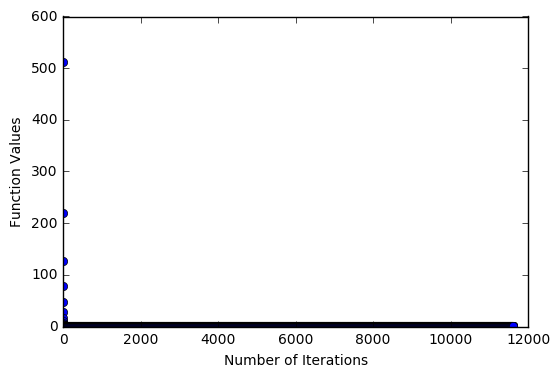

In [11]:
gd.converge_plot()

#### Estimating Gradient Using Automatic Differentiation (Reverse Mode)

In [12]:
gd = Grad_Descent()
ad = AD(rosenbrock)
gd.minimize(rosenbrock, ad.grad_reverse, x0, step=1e-3, iterations=1e5, precision=1e-6)

array([ 0.99989214,  0.99978389,  0.99956681,  0.99913168,  0.99825978])

In [13]:
print(gd.msg)

Optimization Stop Reason: Precision is reached


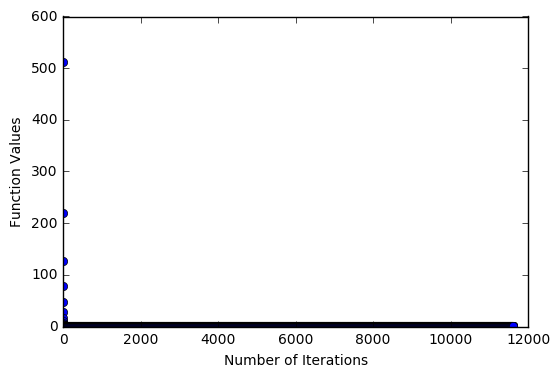

In [14]:
gd.converge_plot()

## Using Nelder-Mead Simplex Method (Derivative Free Optimization)

In [15]:
res = minimize(rosenbrock, x0, method='nelder-mead', options={'xtol': 1e-8})
res.x

array([ 1.,  1.,  1.,  1.,  1.])

## Using BFGS Method

#### Using Analytical Gradient

In [16]:
res = minimize(rosenbrock, x0, method='BFGS', jac=rosenbrock_grad)
res.x

array([ 1.00000004,  1.0000001 ,  1.00000021,  1.00000044,  1.00000092])

#### Estimating Gradient Using Finite Differences

In [17]:
# If jac is False, the gradient will be estimated numerically
res = minimize(rosenbrock, x0, method='BFGS', jac=False)
res.x

array([ 0.99999925,  0.99999852,  0.99999706,  0.99999416,  0.99998833])

#### Estimating Gradient Using Automatic Differentiation (Forward Mode)

In [18]:
gd = Grad_Descent()
ad = AD(rosenbrock)
res = minimize(rosenbrock, x0, method='BFGS', jac=ad.grad_forward)
res.x

array([ 1.00000004,  1.0000001 ,  1.00000021,  1.00000044,  1.00000092])

#### Estimating Gradient Using Automatic Differentiation (Reverse Mode)

In [19]:
res = minimize(rosenbrock, x0, method='BFGS', jac=ad.grad_reverse)
res.x

array([ 1.00000004,  1.0000001 ,  1.00000021,  1.00000044,  1.00000092])

## Using Newton-Conjugate-Gradient Method (Based on Hessian)

#### Using Analytical Hessian

In [20]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=rosenbrock_grad, hess=rosenbrock_hess, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian (Vector Product) Using Finite Differences

In [21]:
# Jacobian is required for Newton-CG method
# If neither hess nor hessp is provided, then the Hessian product will be approximated using finite differences on jac
res = minimize(rosenbrock, x0, method='Newton-CG', jac=rosenbrock_grad, options={'xtol': 1e-8})
res.x

array([ 1.,  1.,  1.,  1.,  1.])

#### Estimating Hessian Using Automatic Differentiation (Forward Mode)

In [22]:
gd = Grad_Descent()
ad = AD(rosenbrock)
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_forward, hess=ad.hess_forward, options={'xtol': 1e-8})
res.x

/Users/dongmingliu/anaconda/lib/python3.5/site-packages/algopy/utpm/utpm.py:1798: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  S = numpy.zeros((N,M), dtype=x.dtype)


array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian Using Automatic Differentiation (Reverse Mode)

In [23]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_reverse, hess=ad.hess_reverse, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

## Using Newton-Conjugate-Gradient Method (Based on Hessian Vector Product)

#### Using Analytical Hessian Vector Product

In [24]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=rosenbrock_grad, hessp=rosenbrock_hess_vector, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian Vector Product Using Automatic Differentiation (Forward Mode)

In [25]:
gd = Grad_Descent()
ad = AD(rosenbrock)
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_forward, hessp=ad.hess_vector_forward, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])

#### Estimating Hessian Vector Product Using Automatic Differentiation (Reverse Mode)

In [26]:
res = minimize(rosenbrock, x0, method='Newton-CG', jac=ad.grad_reverse, hessp=ad.hess_vector_reverse, options={'xtol': 1e-8})
res.x

array([ 1.        ,  1.        ,  1.        ,  0.99999999,  0.99999999])